In [2]:
EMULATORS_PATH = "/Users/gabe/projects/emulators/src"
RECOMBINATION_PATH = "/Users/gabe/projects/recombination/src" 

import sys
import os
import numpy as np
from scipy.interpolate import CubicSpline
import classy as Class
import cmasher as cmr

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d

import scipy.special
from scipy.stats import logistic
from scipy.optimize import fsolve

if EMULATORS_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/emulators/src")
if RECOMBINATION_PATH not in sys.path:
    sys.path.insert(0, "/Users/gabe/projects/recombination/src")
from TrainedEmulator import *
from ChainTools import *

from getdist import plots, MCSamples, loadMCSamples

######################################################
#  Setting up plots
######################################################

%config InlineBackend.figure_format = 'retina'
font = {'size'   : 16, 'family':'serif'}
axislabelfontsize='large'
mpl.rc('font', **font)
plt.rcParams["figure.figsize"] = [8.0,6.0]
plt.rcParams['text.usetex']=True

In [3]:
planck_best_fit_cosmo = {'omega_b': 0.0223828, 
                        'omega_cdm': 0.1201075,
                        'tau_reio': 0.05430842, 
                        'ln10^{10}A_s': 3.044784, 
                        'n_s': 0.9660499, 
                        'H0': 67.32117, }

qi_priors = {"q_1": [-3.5, 3.5],
            "q_2": [-1, 1],
            "q_3": [-3.5, 3.5],
            "q_4": [-1.5, 1.5],
            "q_5": [-6.5, 6.5]}

def create_cp_string(list_of_control_points):

    list_of_control_points = np.insert(list_of_control_points, 0, 0.0)
    list_of_control_points = np.append(list_of_control_points, 0.0)
    str_ctrl = ["{:.4f}".format(c) for c in list_of_control_points]
    str_ctrl = ",".join(str_ctrl)

    return str_ctrl

common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':planck_best_fit_cosmo["H0"],
                   'omega_b':planck_best_fit_cosmo["omega_b"],
                   'omega_cdm':planck_best_fit_cosmo["omega_cdm"],
                   'ln10^{10}A_s': planck_best_fit_cosmo["ln10^{10}A_s"],
                   'n_s':planck_best_fit_cosmo["n_s"],
                   'tau_reio': planck_best_fit_cosmo["tau_reio"],
                  }

precision_settings = {'N_ur': 2.0308,
                  'N_ncdm': 1,
                  'm_ncdm': 0.06,
                  'T_ncdm': 0.71611, #1 species of massive neutrinos
                  'accurate_lensing': 1.0,
                  #'k_max_tau0_over_l_max': 15.00,
                  'perturbations_sampling_stepsize': 0.05,
                  'xe_pert_type': 'none',
                  'start_sources_at_tau_c_over_tau_h': 0.004
                  }
M = Class.Class()
M.set(common_settings)
M.set(precision_settings)
M.compute(level=["thermodynamics"])

thermo_fid = M.get_thermodynamics()
xe_func_fid = interp1d(thermo_fid["z"], thermo_fid["x_e"])
Yp = M.get_current_derived_parameters(['YHe'])['YHe']
xe_max_fid = 1 + Yp/2*(1-Yp)

In [4]:
######################################################
#  Choosing parameters of model
######################################################

zmin_pert = 800
zmax_pert = 1600
num_free_control_points = 5

pivots = np.linspace(zmin_pert, zmax_pert, 7)
free_pivots = pivots[1:-1]
pivots_str = ",".join(["{:.4f}".format(p) for p in pivots])
zgrid = np.linspace(zmin_pert-300, zmax_pert+300, 1000)

print("There are {} free control points placed at:".format(num_free_control_points))
print(free_pivots)

######################################################
#  Setting general class settings
######################################################
common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':planck_best_fit_cosmo["H0"],
                   'omega_b':planck_best_fit_cosmo["omega_b"],
                   'omega_cdm':planck_best_fit_cosmo["omega_cdm"],
                   'ln10^{10}A_s': planck_best_fit_cosmo["ln10^{10}A_s"],
                   'n_s':planck_best_fit_cosmo["n_s"],
                   'tau_reio': planck_best_fit_cosmo["tau_reio"],
                  }

precision_settings = {'N_ur': 2.0308,
                  'N_ncdm': 1,
                  'm_ncdm': 0.06,
                  'T_ncdm': 0.71611, #1 species of massive neutrinos
                  'accurate_lensing': 1.0,
                  #'k_max_tau0_over_l_max': 15.00,
                  'perturbations_sampling_stepsize': 0.05,
                  'xe_pert_type': 'control',
                  'xe_pert_num': 7,
                  'xe_control_pivots': pivots_str,
                  'zmin_pert': zmin_pert,
                  'zmax_pert': zmax_pert,
                  'start_sources_at_tau_c_over_tau_h': 0.004
                  }

There are 5 free control points placed at:
[ 933.33333333 1066.66666667 1200.         1333.33333333 1466.66666667]


In [5]:
p = lambda z: scipy.special.logit(xe_func_fid(z)/xe_max_fid)

@np.vectorize
def rescale_pert_amp(q, z, xe_fid, xe_max):
    shift = scipy.special.logit(xe_func_fid(z)/xe_max_fid)
    return scipy.special.expit(q+shift)*xe_max - xe_fid(z)

@np.vectorize
def inverse_pert_transformation(qt,z, xe_fid, xe_max):
    shift = fsolve(lambda aa: scipy.special.expit(aa)*xe_max - xe_fid(z), 0)
    return scipy.special.logit( (qt+xe_fid(z))/xe_max ) - shift

In [6]:
upper_limit = CubicSpline(zgrid, rescale_pert_amp(100, zgrid, xe_func_fid, xe_max_fid))
lower_limit = CubicSpline(zgrid, rescale_pert_amp(-100, zgrid, xe_func_fid, xe_max_fid))

[-3.9687171367030922, -2.2488327120436336, -0.8702255430918493, 0.3686747599118125, 1.6669835648008289]


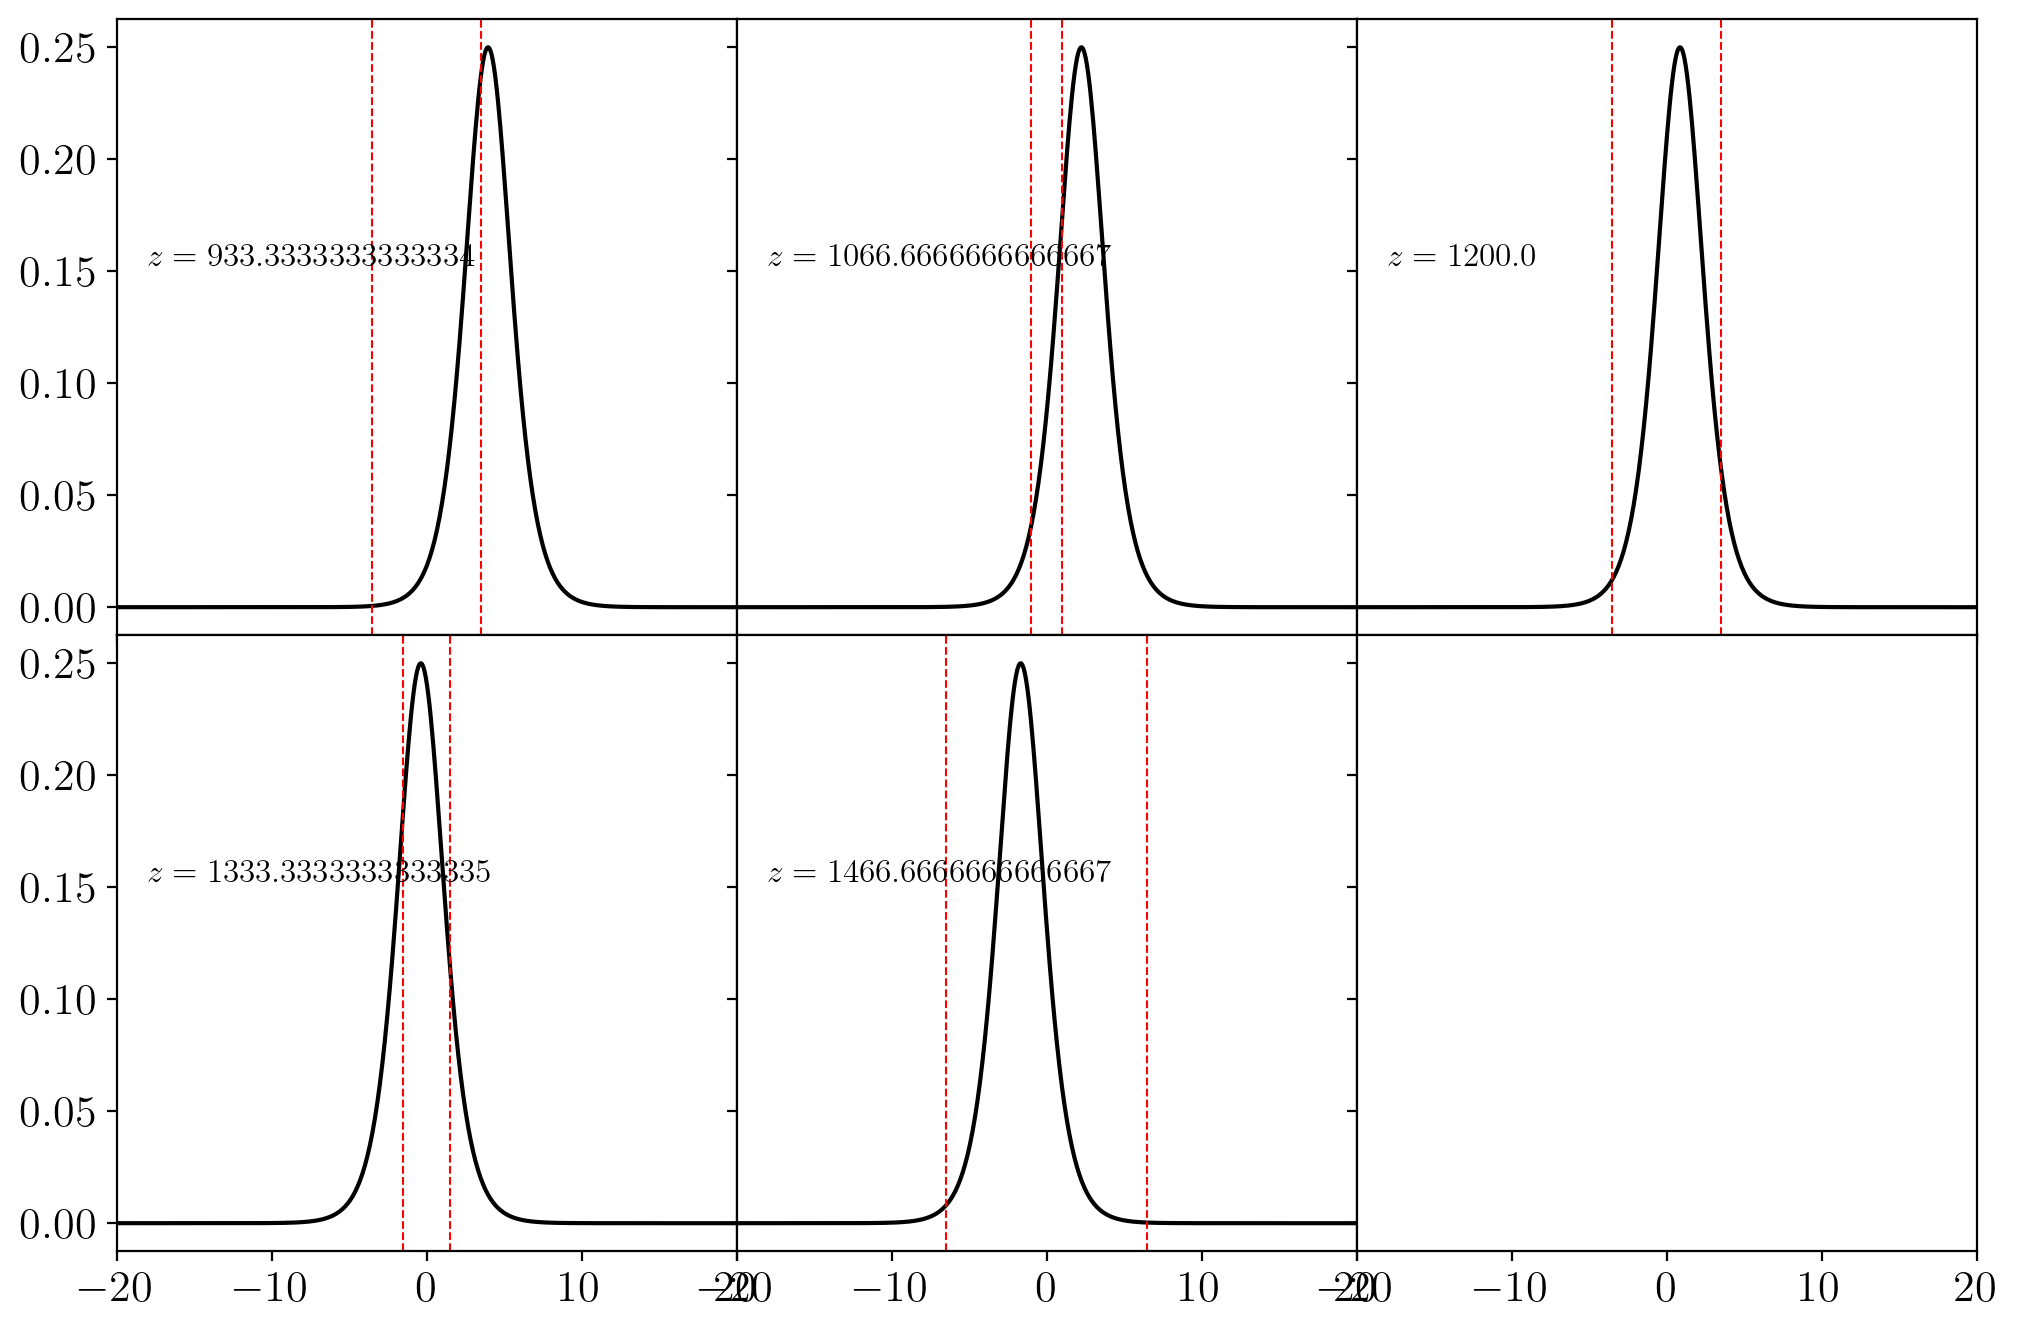

In [7]:
fig,axes = plt.subplots(2, 3, figsize=(12,8), sharex='col', sharey='row')
qi_priors_old = {"q_1": [-3.5, 3.5],
            "q_2": [-1, 1],
            "q_3": [-3.5, 3.5],
            "q_4": [-1.5, 1.5],
            "q_5": [-6.5, 6.5],
            "q_6": [-6.5, 6.5]}

xgrid = np.linspace(-20, 20, 500)
shifts = [p(f) for f in free_pivots]

print(shifts)

fig.subplots_adjust(hspace=0.0, wspace=0.0)
for i in np.arange(5):
    ax = axes.flatten()[i]
    ax.plot(xgrid, logistic(loc=-shifts[i]).pdf(xgrid), color="black")
    ax.axvline(qi_priors_old["q_{}".format(i+1)][0], color="red", linestyle="dashed", linewidth=0.75)
    ax.axvline(qi_priors_old["q_{}".format(i+1)][1],  color="red", linestyle="dashed", linewidth=0.75)
    ax.text(0.05, 0.6, "$z={}$".format(free_pivots[i]), transform=ax.transAxes, fontsize=12)
    ax.set_xlim([-20, 20])

In [8]:
num_draws = 5000

input_cp_dict = {"q_{}".format(i):logistic(loc=-shifts[i]).rvs(size=num_draws) for i in np.arange(len(free_pivots)) }

M = Class.Class()

M.set(precision_settings)

xe_list = []
delta_xe_list = []
for i in np.arange(num_draws):
    cp_list = [input_cp_dict["q_{}".format(j)][i] for j in np.arange(len(free_pivots))]
    cp_str = create_cp_string(cp_list)
    common_settings.update({"xe_control_points":cp_str})
    M.set(common_settings)
    try:
        M.compute(level=["thermodynamics"])
        thermo = M.get_thermodynamics()
        xe_out = CubicSpline(thermo["z"], thermo["x_e"])(zgrid)
        xe_list.append(xe_out)

        delta_xe_out = CubicSpline(thermo["z"], thermo["xe_pert"])(zgrid)
        delta_xe_list.append(delta_xe_out)
    except Exception as e :
        print(e)
        continue



Error in Class: thermodynamics_init(L:353) :error in thermodynamics_solve(ppr,pba,pth,ptw,pvecback);
=>thermodynamics_solve(L:1696) :error in thermodynamics_reionization_evolve_with_tau(&tpaw, interval_limit[index_interval], interval_limit[index_interval+1], mz_output, pth->tt_size);
=>thermodynamics_reionization_evolve_with_tau(L:2379) :condition (tau_inf > pth->tau_reio) is true; CLASS cannot reach the low value of tau_reio that was selected, even when setting z_reio as low as 0.
This means that some additional physical component is requiring some minimal tau_reio_min = 2.3501131586e+01.
This is usually caused by strong energy injections or other modifications of the x_e(z) behaviour.


Error in Class: thermodynamics_init(L:353) :error in thermodynamics_solve(ppr,pba,pth,ptw,pvecback);
=>thermodynamics_solve(L:1696) :error in thermodynamics_reionization_evolve_with_tau(&tpaw, interval_limit[index_interval], interval_limit[index_interval+1], mz_output, pth->tt_size);
=>thermodynamic

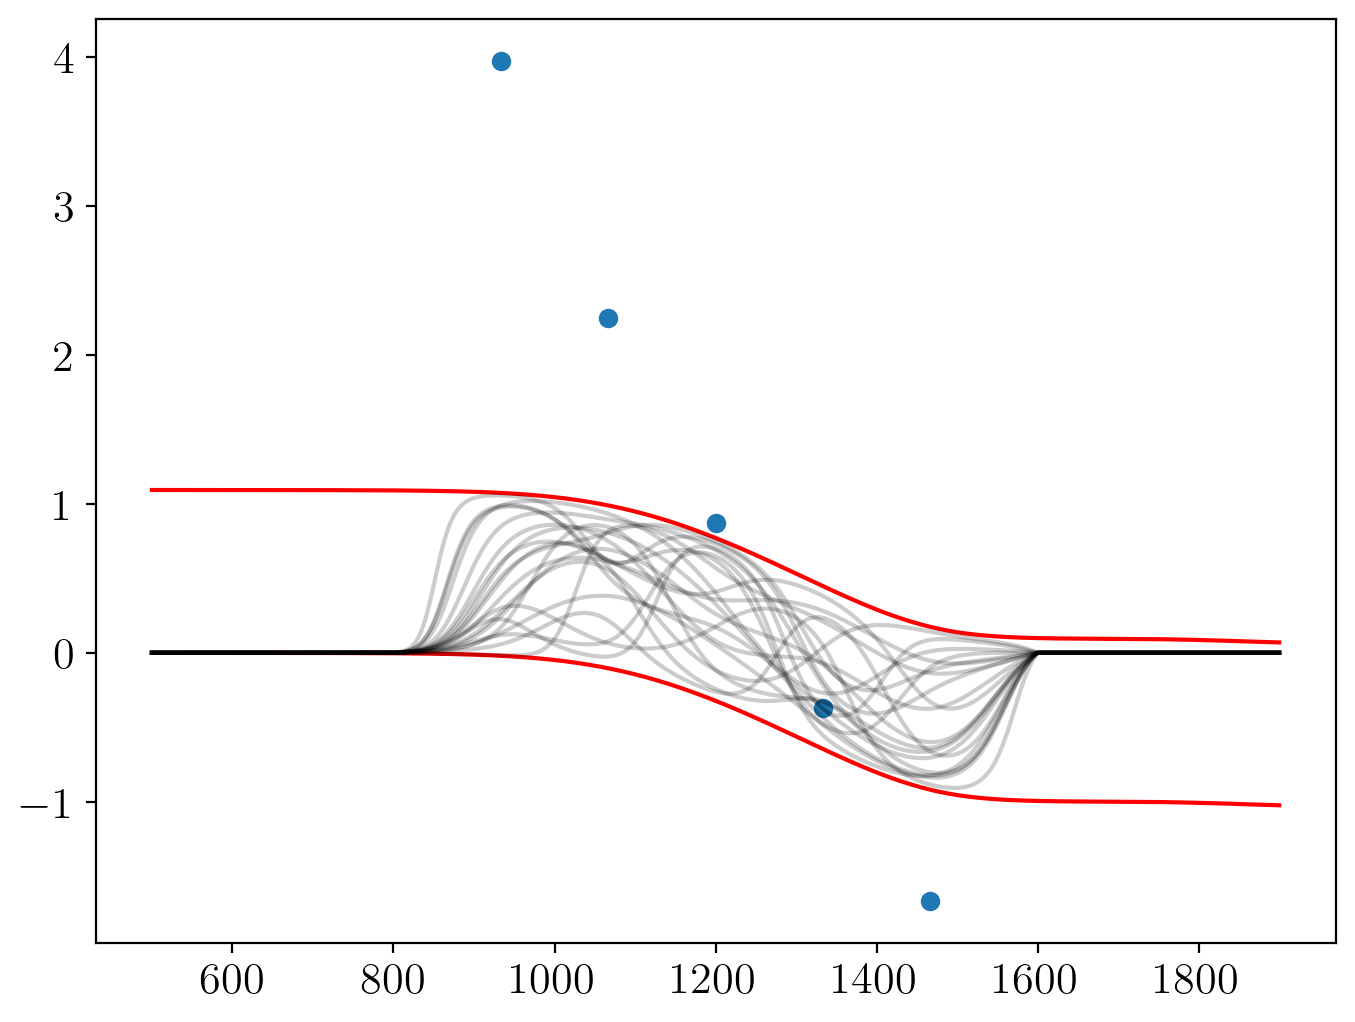

In [9]:
fig,ax = plt.subplots()

ax.plot(zgrid, upper_limit(zgrid), color="red")
ax.plot(zgrid, lower_limit(zgrid), color="red")

for xe in delta_xe_list[:20]:
    ax.plot(zgrid, xe, color="black", alpha=.2)

ax.scatter(free_pivots, -np.array(shifts))

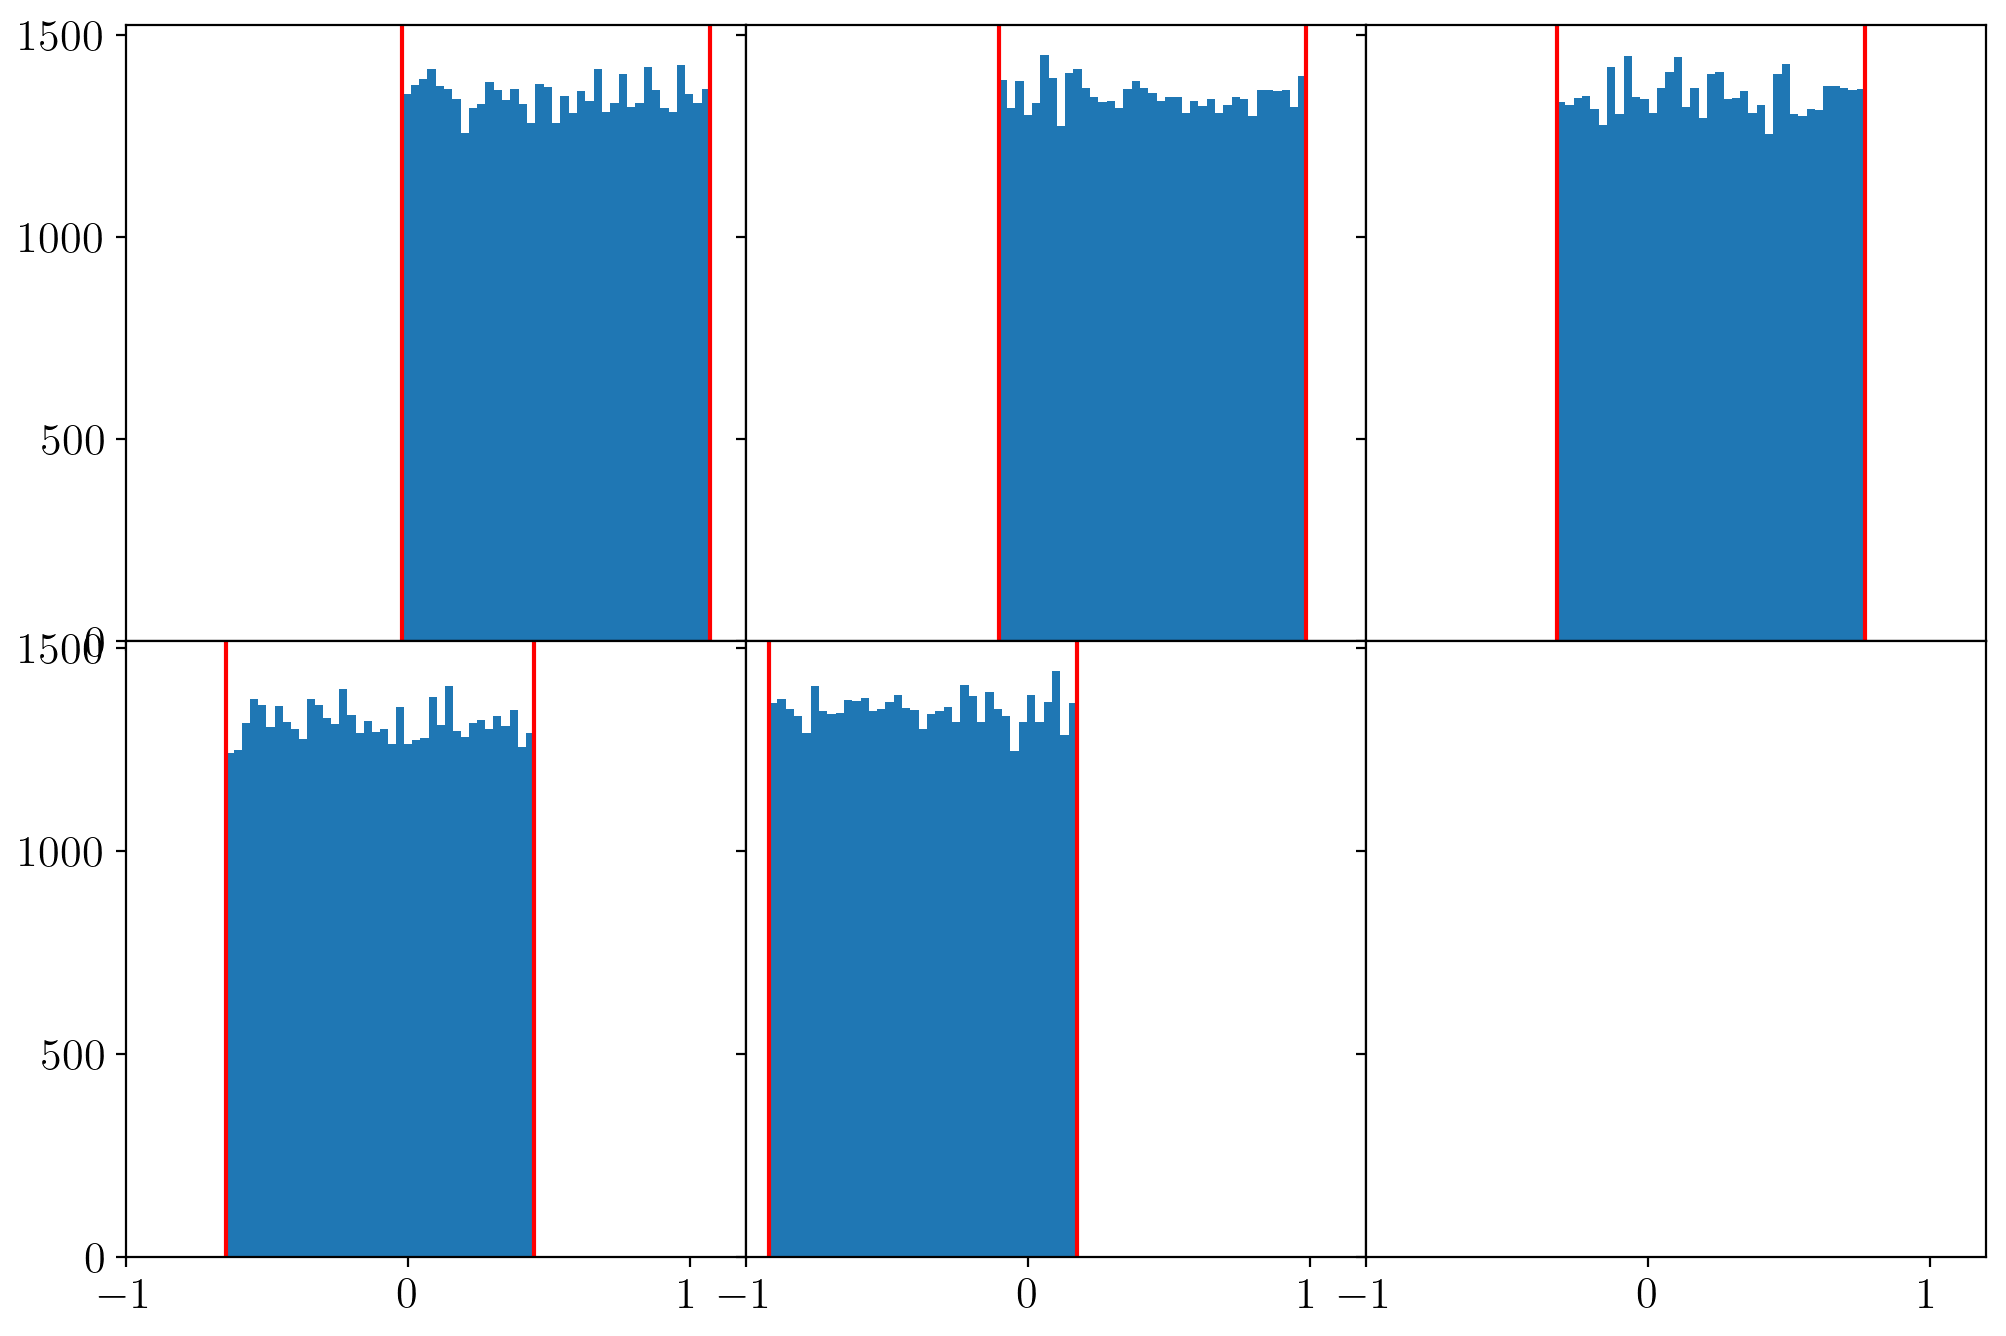

In [10]:
fig,axes = plt.subplots(2, 3, figsize=(12,8), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.0, wspace=0.0)

xgrid = np.linspace(-20, 20, 500)
shifts = [p(f) for f in free_pivots]

N_draws = 50000
for i in np.arange(5):
    ax = axes.flatten()[i]
    test_draws = logistic(loc=-shifts[i]).rvs(N_draws)
    transformed_draws = rescale_pert_amp(test_draws, free_pivots[i], xe_func_fid, xe_max_fid)
    ax.hist(transformed_draws, bins='fd')
    ax.axvline(upper_limit(free_pivots[i]), color="red")
    ax.axvline(lower_limit(free_pivots[i]), color="red")
    ax.set_xlim([-1, 1.2])

#plt.savefig("../results/transformed_prior_draws.png",dpi=300, bbox_inches='tight')

In [11]:
fine_grid = np.linspace(min(zgrid), max(zgrid), 1000)

trajectories = np.vstack([interp1d(zgrid, y)(fine_grid) for y in delta_xe_list])

y_range = [-xe_max_fid, xe_max_fid]
#y_range = [0,1.1]
h, bins = construct_trajectory_heatmap(trajectories, y_range=y_range, num_bins=1000)

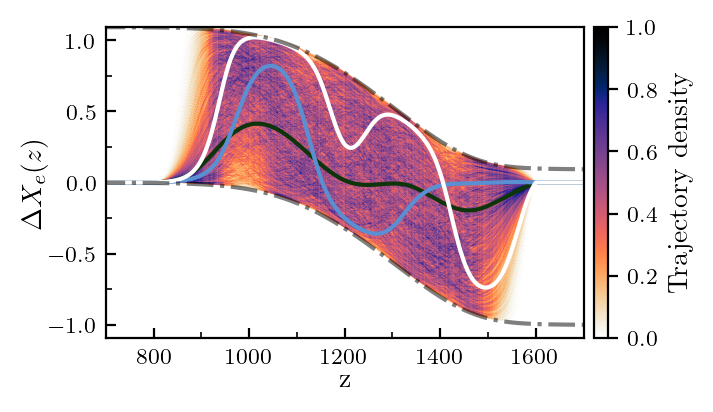

In [17]:
fig,ax = plt.subplots() 
fig.set_size_inches(w=3.24, h=2.02)

m=ax.imshow(h, cmap=mpl.cm.get_cmap('cmr.torch_r'), origin="lower", extent=[np.min(fine_grid), np.max(fine_grid), np.min(bins),np.max(bins)], aspect="auto")

random_traj_to_plot = trajectories[np.random.choice(np.arange(len(trajectories)), size=3, replace=False )]

#ax.set_prop_cycle(color=[mpl.cm.get_cmap("Accent").colors[i] for i in np.arange(3)])
ax.set_prop_cycle(color=mpl.cm.get_cmap("cmr.horizon")(np.linspace(0,1,3)) )
for t in random_traj_to_plot:
    ax.plot(fine_grid, t, )

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)

ax.set_xlim([700, 1700])
ax.set_ylim(y_range)
ax.plot(fine_grid, upper_limit(fine_grid), color="black", linestyle="dashdot", alpha=0.5)
ax.plot(fine_grid, lower_limit(fine_grid), color="black", linestyle="dashdot", alpha=0.5)



ax.tick_params(axis = 'x', which = 'major', direction="in", labelsize = 8)
ax.tick_params(axis = 'x', which = 'minor', direction="in", labelsize = 0)
ax.tick_params(axis = 'y', which = 'major', direction="in", labelsize = 8)
ax.tick_params(axis = 'y', which = 'minor', direction="in", labelsize = 0)

ax.set_xticks([800, 900, 1100, 1200, 1300, 1400, 1500], minor=True)
ax.set_yticks([-.75, -.5, -.25, .25, .5, .75], minor=True)

ax.set_xlabel("z", fontsize=10, labelpad=0)
ax.set_ylabel("$\Delta X_e(z)$", fontsize=10, labelpad=0)

#ax.set_ylabel("${}(z)$".format(quantity))
cb = plt.colorbar(m, cax=cax)
cb.set_label(label="Trajectory density",size=10)
cb.ax.tick_params(labelsize=8)

plt.savefig("../results/delta_xe_prior_sample.pdf",dpi=300, bbox_inches='tight', pad_inches=0)

In [16]:
gauss = scipy.stats.norm()
sig = 1.5
confidence = gauss.cdf(sig) - gauss.cdf(-sig)
tail = (1-confidence)/2.
print(tail)
print(confidence)

0.06680720126885809
0.8663855974622838


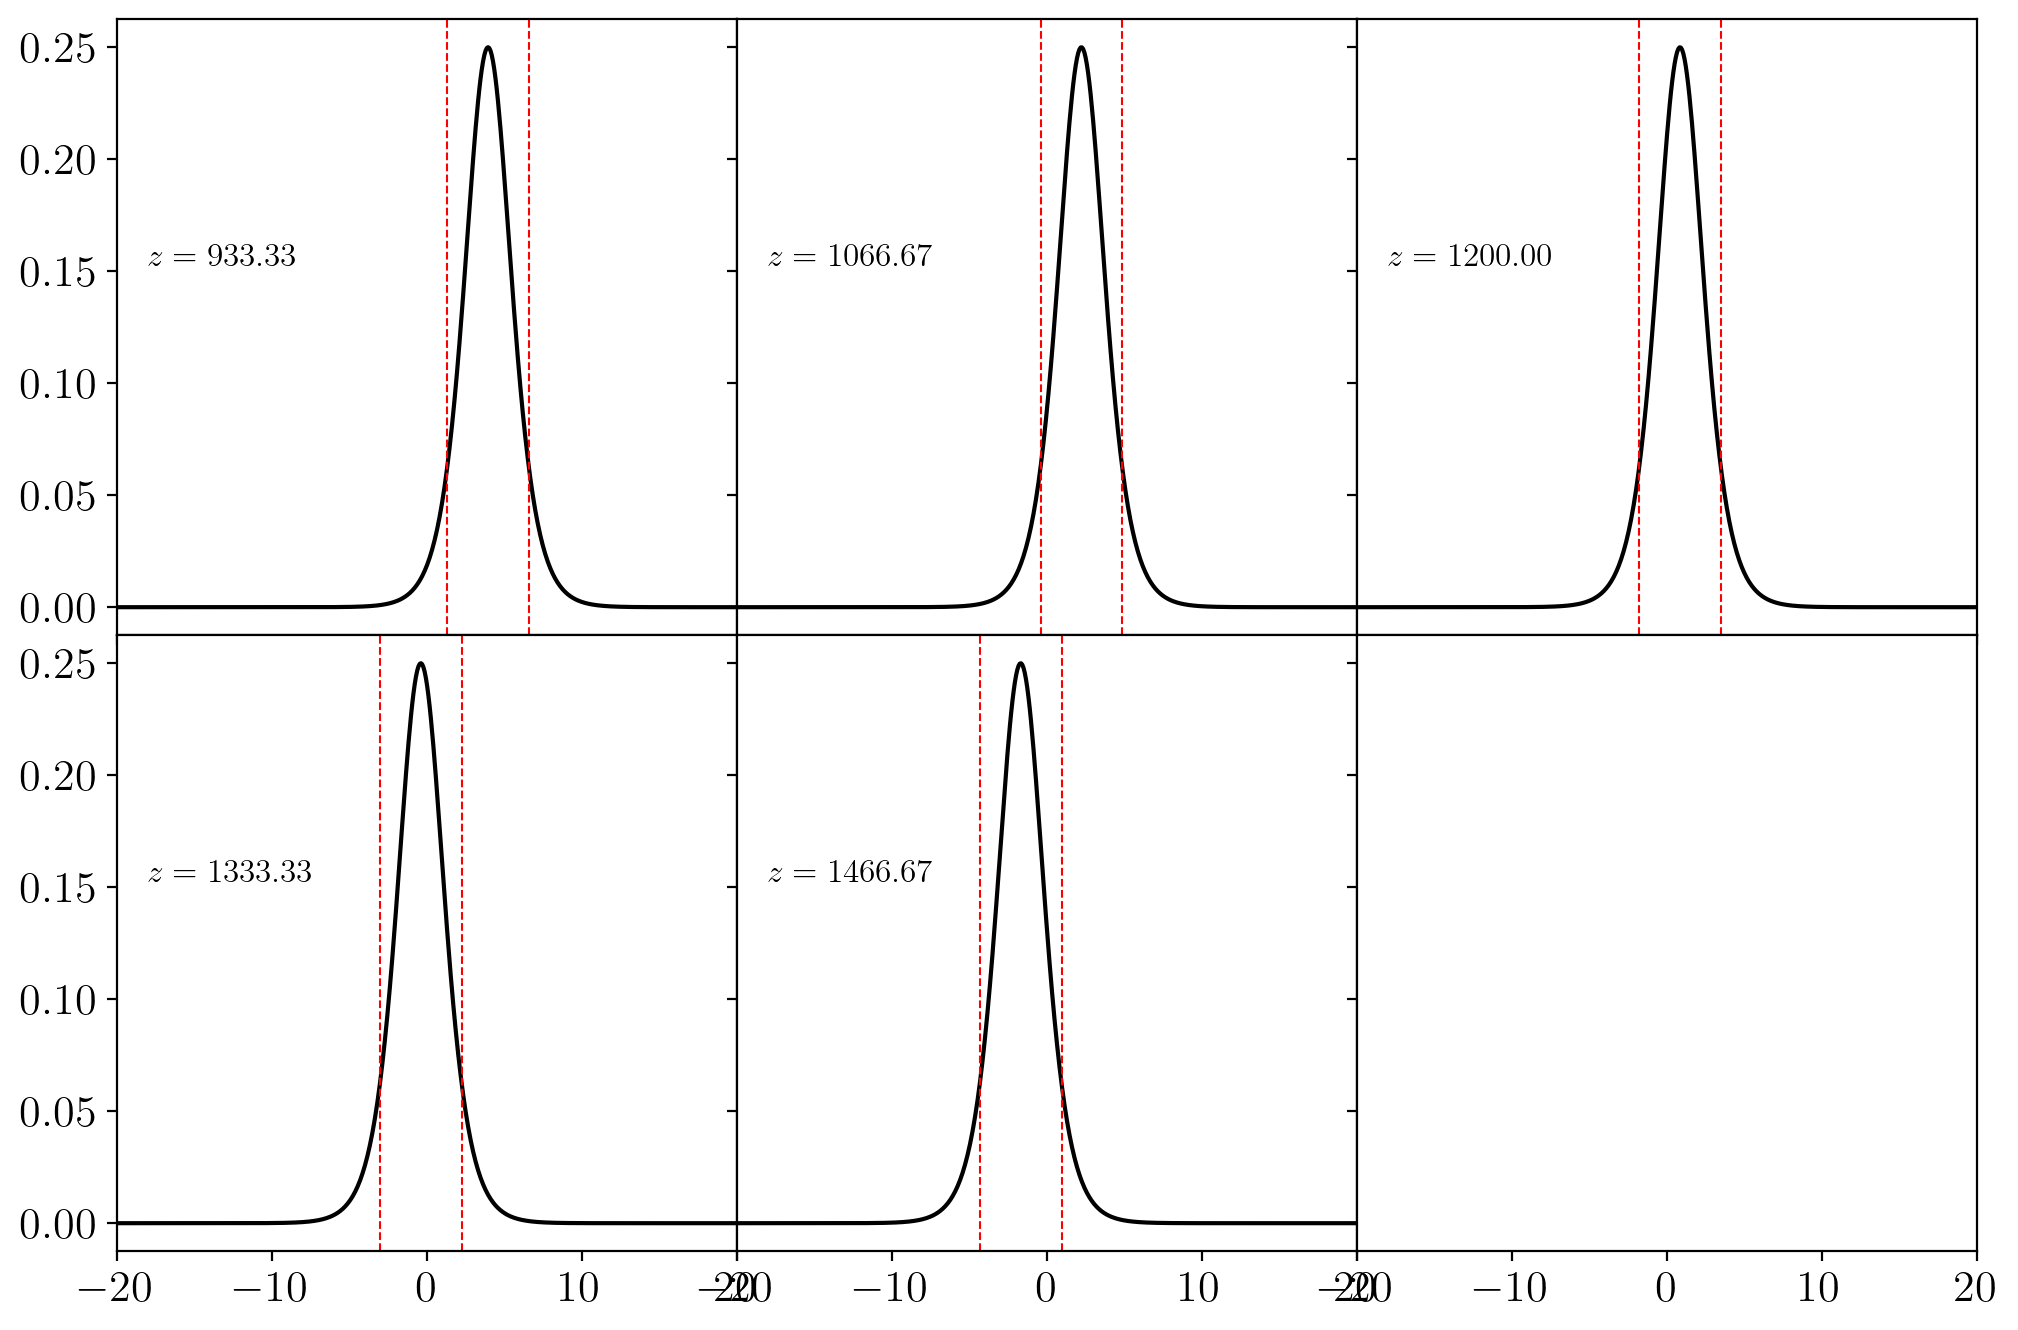

In [17]:
fig,axes = plt.subplots(2, 3, figsize=(12,8), sharex='col', sharey='row')
qi_priors = {}

xgrid = np.linspace(-20, 20, 500)
shifts = [p(f) for f in free_pivots]

fig.subplots_adjust(hspace=0.0, wspace=0.0)
for i in np.arange(5):
    ax = axes.flatten()[i]
    mean = -shifts[i]
    prior = logistic(loc=mean)
    result = fsolve(lambda sigma: 1-prior.cdf(sigma) - tail,mean+1)[0]
    result = result - (mean)
    ax.plot(xgrid, logistic(loc=mean).pdf(xgrid), color="black")
    ax.axvline(mean+result, color="red", linestyle="dashed", linewidth=0.75)
    ax.axvline(mean-result,  color="red", linestyle="dashed", linewidth=0.75)
    qi_priors["q_{}".format(i+1)] = [mean-result, mean+result]
    ax.text(0.05, 0.6, "$z={:.2f}$".format(free_pivots[i]), transform=ax.transAxes, fontsize=12)
    ax.set_xlim([-20, 20])

#plt.savefig("../results/control_priors_with_bounds.png",dpi=300, bbox_inches='tight')

In [18]:
idx = 0
print("Free pivots {}".format(free_pivots))
print("Pivots str {}".format(pivots_str))
for k,v in qi_priors.items():
    #print(v+shifts[idx])
    print("{} @ z={:.3f}: µ={:.5f}, priors={}".format(k, free_pivots[idx], -shifts[idx], v))
    idx+=1

Free pivots [ 933.33333333 1066.66666667 1200.         1333.33333333 1466.66666667]
Pivots str 800.0000,933.3333,1066.6667,1200.0000,1333.3333,1466.6667,1600.0000
q_1 @ z=933.333: µ=3.96872, priors=[1.3319161914914357, 6.605518081914749]
q_2 @ z=1066.667: µ=2.24883, priors=[-0.38796823316802165, 4.885633657255289]
q_3 @ z=1200.000: µ=0.87023, priors=[-1.7665754021198055, 3.507026488303504]
q_4 @ z=1333.333: µ=-0.36867, priors=[-3.0054757051234677, 2.2681261852998427]
q_5 @ z=1466.667: µ=-1.66698, priors=[-4.303784510012484, 0.9698173804108263]


## Estimating effects of chopping off tails

In [19]:
common_settings = {'output' : 'tCl,pCl,lCl',
                   # LambdaCDM parameters
                   'H0':planck_best_fit_cosmo["H0"],
                   'omega_b':planck_best_fit_cosmo["omega_b"],
                   'omega_cdm':planck_best_fit_cosmo["omega_cdm"],
                   'ln10^{10}A_s': planck_best_fit_cosmo["ln10^{10}A_s"],
                   'n_s':planck_best_fit_cosmo["n_s"],
                   'tau_reio': planck_best_fit_cosmo["tau_reio"],
                  }

precision_settings = {'N_ur': 2.0308,
                  'N_ncdm': 1,
                  'm_ncdm': 0.06,
                  'T_ncdm': 0.71611, #1 species of massive neutrinos
                  'accurate_lensing': 1.0,
                  'lensing': 'yes',
                  #'k_max_tau0_over_l_max': 15.00,
                  'perturbations_sampling_stepsize': 0.05,
                  'xe_pert_type': 'control',
                  'xe_pert_num': 7,
                  'xe_control_pivots': pivots_str,
                  'zmin_pert': zmin_pert,
                  'zmax_pert': zmax_pert,
                  'start_sources_at_tau_c_over_tau_h': 0.004
                  }

In [20]:
num_draws = 500

input_cp_dict = {}

for i in np.arange(len(free_pivots)):
    final_array = []
    q_label = "q_{}".format(i+1)
    j=0
    while j<num_draws:
        x = logistic(loc=-shifts[i]).rvs()
        if qi_priors[q_label][0] <= x <= qi_priors[q_label][1]:
            final_array.append(x)
            j+=1
    input_cp_dict[q_label] = np.array(final_array)

M = Class.Class()

M.set(precision_settings)

xe_list = []
delta_xe_list = []
cl_dict_list = []
for i in np.arange(num_draws):
    if(i%100==0):
        print(i)
    cp_list = [input_cp_dict["q_{}".format(j+1)][i] for j in np.arange(len(free_pivots))]
    cp_str = create_cp_string(cp_list)
    common_settings.update({"xe_control_points":cp_str})
    M.set(common_settings)
    try:
        M.compute()
        thermo = M.get_thermodynamics()
        xe_out = CubicSpline(thermo["z"], thermo["x_e"])(zgrid)
        xe_list.append(xe_out)
        cls = M.lensed_cl()
        outdict = {"ell": cls["ell"], "tt": cls["tt"], "te": cls["te"], "ee":cls["ee"]}
        cl_dict_list.append(outdict)
        delta_xe_out = CubicSpline(thermo["z"], thermo["xe_pert"])(zgrid)
        delta_xe_list.append(delta_xe_out)
    except Exception as e :
        print(e)
        continue

0
100
200
300
400


In [21]:
fine_grid = np.linspace(min(zgrid), max(zgrid), 1000)

trajectories = np.vstack([interp1d(zgrid, y)(fine_grid) for y in delta_xe_list])

y_range = [-xe_max_fid, xe_max_fid]
#y_range = [0,1.1]
h, bins = construct_trajectory_heatmap(trajectories, y_range=y_range, num_bins=1000)

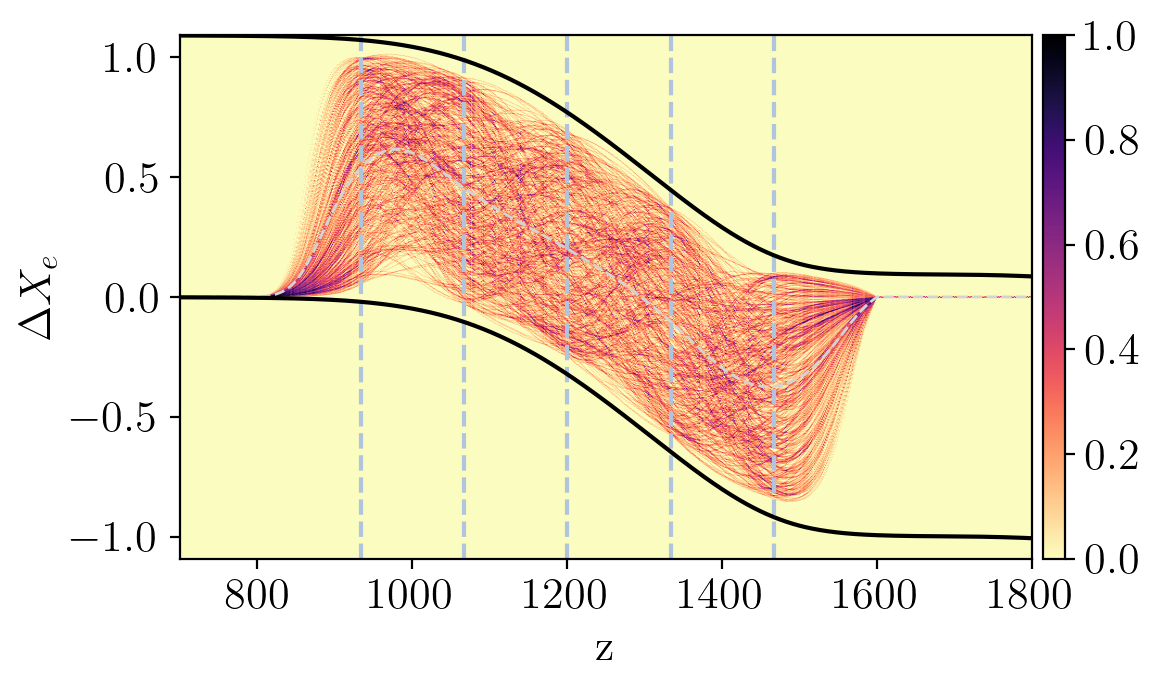

In [33]:
fig,ax = plt.subplots() 
fig.set_size_inches(w=5.5, h=3.4)

m=ax.imshow(h, cmap=mpl.cm.get_cmap('magma_r'), origin="lower", extent=[np.min(fine_grid), np.max(fine_grid), np.min(bins),np.max(bins)], aspect="auto")
ax.plot(fine_grid,np.mean(trajectories, axis=0), color="lightgray", linewidth=1, linestyle="dashed")
#ax.set_title(chain_name)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])

for piv in free_pivots:
    ax.axvline(piv, linestyle="dashed", color="lightsteelblue")

ax.set_xlabel("z")
ax.set_xlim([700, 1800])
ax.set_ylim(y_range)
ax.plot(fine_grid, upper_limit(fine_grid), color="black")
ax.plot(fine_grid, lower_limit(fine_grid), color="black")
#for pivot in free_pivots:
#    ax.axvline(pivot, linestyle="dotted", color="lightsteelblue")
#ax.set_ylabel("${}(z)$".format(quantity))
ax.set_ylabel("$\Delta X_e$")
#ax.set_title("${:.2f} < {} < {:.2f}$".format(selection_criteria["H0"][0], "H_0", selection_criteria["H0"][1]))
plt.colorbar(m, cax=cax)
#plt.savefig("../results/delta_xe_2p5sigma.png",dpi=300, bbox_inches='tight')

# Emualtor eval

In [24]:
emulator_dir = "/Users/gabe/projects/emulators/models"
emulator_name = "modrec_new_2"

em = TrainedEmulator(os.path.join(emulator_dir, emulator_name))

2023-08-22 09:55:01.843434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
in_models = {'H0': np.full(num_draws, planck_best_fit_cosmo["H0"]),
            'omega_b': np.full(num_draws, planck_best_fit_cosmo["omega_b"]),
            'omega_cdm': np.full(num_draws, planck_best_fit_cosmo["omega_cdm"]),
            'ln10^{10}A_s': np.full(num_draws, planck_best_fit_cosmo["ln10^{10}A_s"]),
            'n_s':np.full(num_draws, planck_best_fit_cosmo["n_s"]),
            'tau_reio': np.full(num_draws, planck_best_fit_cosmo["tau_reio"]),
            'q_1': input_cp_dict["q_1"],
            'q_2': input_cp_dict["q_2"],
            'q_3': input_cp_dict["q_3"],
            'q_4': input_cp_dict["q_4"],
            'q_5': input_cp_dict["q_5"],
            }

predictions = em.get_predictions_dict(in_models)

(-9e-12, 9e-10)

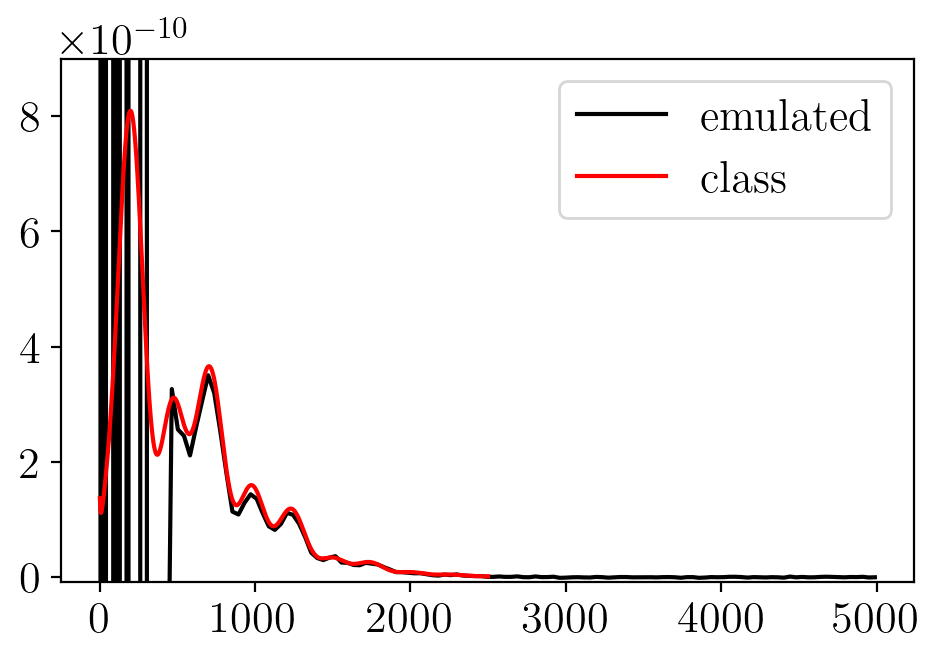

In [32]:
fig  = plt.figure( )
fig.set_size_inches(w=5.5, h=3.4)
ax = plt.subplot()

ll = em.output_info["output_z_grids"]["x_e"]
ll=em.ell
ll_full = np.arange(2, 2501)
idx = 53
spec="tt"
#for i in np.arange(20):
ax.plot(ll, predictions[spec][idx],color="black", label="emulated")
ax.plot(ll_full, ll_full*(ll_full+1)/(2*np.pi)*cl_dict_list[idx][spec][2:],color="red", label="class")
ax.legend()
#ax.scatter(ll, np.full(ll.shape, 5e-10), s=3, marker=".")
ax.set_ylim([-9e-12, 9e-10])
#ax.set_xlim([1, 1000])